In [102]:
# Author: M. Riley Owens (GitHub: mrileyowens)

# This file creates a figure displaying the Sunburst Arc
# and its cluster field with inset axes zooming in on the
# two largest arcs with the different images and MagE slit
# apertures overlaid.

In [103]:
import os

import numpy as np

from regions import CircleSkyRegion, RectangleSkyRegion

from reproject import reproject_interp

from astropy.io import fits
from astropy.wcs import WCS

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.visualization.wcsaxes import add_scalebar

from scipy.ndimage import rotate, map_coordinates

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch as cp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
import matplotlib.patheffects as pe

In [104]:
def plot():
    
    def rotate_wcs(wcs, angle):

        '''
        Rotates a WCS projection by some angle

        Parameters:

            wcs : astropy.wcs.wcs.WCS
                The original WCS projection

            angle : int
                The angle (in degrees) to rotate the WCS projection

        Returns:

            rotated_wcs : astropy.wcs.wcs.WCS
                The rotated WCS projection
        '''

        # Define the rotation angle
        angle = Angle(angle, unit='deg')

        # Get the CD matrix from the original WCS projection
        cd_matrix = wcs.wcs.cd

        # Calculate the rotation matrix
        cos_angle = np.cos(angle.rad)
        sin_angle = np.sin(angle.rad)
        rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]], dtype=np.float64)

        # Apply the rotation to the CD matrix
        rotated_cd_matrix = np.dot(cd_matrix, rotation_matrix)

        # Update the CD matrix in the rotated WCS projection
        rotated_wcs = wcs.deepcopy()
        rotated_wcs.wcs.cd = rotated_cd_matrix

        return rotated_wcs

    def add_inset_axes(fig, ax_bbox, wcs_inset, left_coord, bottom_coord, ax_inset_width, ax_inset_height):

        '''
        Add an inset axes to the main axes

        Parameters:

            fig : matplotlib.figure.Figure
                The figure object of the main axes

            ax_bbox : matplotlib.transforms.Bbox
                The bounding box of the main axes

            wcs_inset : astropy.wcs.wcs.WCS
                The WCS projection of the inset axes

            left_coord : float
                The x-coordinate of the lower left corner of the 
                inset axes in units of fraction of the main axes

            bottom_coord : float
                The y-coordinate of the lower left corner of the 
                inset axes in units of fraction of the main axes

            ax_inset_width : float
                The width of the inset axes in units of fraction 
                of the main axes
            
            ax_inset_height : float
                The height of the inset axes in units of fraction
                of the main axess

        Returns:

            ax_inset : astropy.visualization.wcsaxes.core.WCSAxes
                The WCS projection-imbued inset axes
        '''

        # Convert the lower left corner of the inset to figure coordinates
        fig_left = ax_bbox.x0 + left_coord * ax_bbox.width
        fig_bottom = ax_bbox.y0 + bottom_coord * ax_bbox.height

        # Convert the width and height of the inset to figure coordinates
        fig_width = ax_inset_width * ax_bbox.width
        fig_height = ax_inset_height * ax_bbox.height

        # Add the inset axes to the figure with the inset WCS projection
        ax_inset = fig.add_axes([fig_left, fig_bottom, fig_width, fig_height], projection=wcs_inset)

        return ax_inset    

    def set_inset_axes_limits(ax_inset, wcs_inset, wcs_main, center, angle, corner_1, corner_2):

        '''
        Set the coordinate limits of the inset axes

        Parameters:

            ax_inset : astropy.visualization.wcsaxes.core.WCSAxes
                The WCS projection-imbued inset axes

            wcs_inset : astropy.wcs.wcs.WCS
                The WCS projection of the inset axes

            wcs_main : astropy.wcs.wcs.WCS
                The WCS projection of the main axes

            center : tuple
                The center of the inset axes in pixel coordinates of the main axes

            angle : int
                The angle in degrees that the delineating area of the inset 
                axes on the main axes is rotated relative to the main axes

            corner_1 : list
                The pixel coordinates in the main axes of the first corner
                used to evaluate the inset axes limits. The coordinates are
                before rotating the delineating area of the inset axes on 
                the main axes

            corner_2 : list
                The pixel coordinates in the main axes of the second corner
                used to evaluate the inset axes limits. The coordinates are
                before rotating the delineating area of the inset axes on 
                the main axes
        '''

        # Rotate the corners around the center by the angle, converting from pixel to world values, and then back to pixel values in the inset
        # axes WCS projection
        corner_1_rotated = wcs_inset.world_to_pixel_values([wcs_main.pixel_to_world_values([[*rotate_point(corner_1, center, angle)]])[0]])[0]
        corner_2_rotated = wcs_inset.world_to_pixel_values([wcs_main.pixel_to_world_values([[*rotate_point(corner_2, center, angle)]])[0]])[0]
        
        # Set the axes limits based on the rotated corners' positions in the inset axes WCS projection
        ax_inset.set_xlim(corner_1_rotated[0], corner_2_rotated[0])
        ax_inset.set_ylim(corner_1_rotated[1], corner_2_rotated[1])

    def rotate_point(point, center, angle):

        '''
        Rotate a point around some center by some angle

        Parameters:

            point : list
                Pixel coordinates of the point to rotate

            center : tuple
                Center in pixel coordinates to rotate the point about

            angle : int
                Angle in degrees to rotate the point
        
        Returns:

            rotated_point : numpy.ndarray
                Pixel coordinates of the rotated point
        '''

        # Translate the point to coordinates with the center as origin
        translated_point = np.array([point[0] - center[0], point[1] - center[1]])
    
        # Define the rotation matrix
        theta = np.radians(angle)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ])
    
        # Apply the rotation
        rotated_point = translated_point @ rotation_matrix.T
    
        # Translate the point back to coordinates with the original origin
        rotated_point += np.array(center)
    
        return rotated_point

    def add_box(fig, ax, ax_inset, center, width, height, angle, ax_inset_corners, box_corners):

        '''
        Add a box on the main axes delineating the area enlarged in the inset axes

        Parameters:

            fig : matplotlib.figure.Figure
                The figure object of the main axes

            ax : astropy.visualization.wcsaxes.core.WCSAxes
                The WCS projection-imbued main axes

            ax_inset : astropy.visualization.wcsaxes.core.WCSAxes, NoneType
                The WCS projection-imbued inset axes

            center : tuple
                Pixel coordinates of the center of the box

            width : int
                Width of the box in pixels

            height : int
                Height of the box in pixels

            angle : int
                Angle to rotate the box in degrees

            ax_inset_corners : list, NoneType
                Axes coordinates of the inset axes where the connecting lines will terminate

            box_corners : list, NoneType
                Pixel coordinates of the main axes where the connecting lines will start
        '''

        # Make the box
        arc = patches.Rectangle((center[0] - width / 2, center[1] - height / 2), width, height, 
            angle=angle, rotation_point='center', linewidth=1, linestyle='dashed', edgecolor='black', facecolor='none')

        # Add the box to the main axes
        ax.add_patch(arc)

        if ax_inset != None:

            # Make the connecting lines matching the box to the corresponding axes
            line1 = cp(xyA=(rotate_point(box_corners[0], center, angle)), xyB=ax_inset_corners[0], coordsA='data', 
                coordsB='axes fraction', axesA=ax, axesB=ax_inset, color='black', linestyle='dashed', lw=1)
            line2 = cp(xyA=(rotate_point(box_corners[1], center, angle)), xyB=ax_inset_corners[1], coordsA='data', 
                coordsB='axes fraction', axesA=ax, axesB=ax_inset, color='black', linestyle='dashed', lw=1)

            # Add the connecting lines to the figure
            fig.add_artist(line1)
            fig.add_artist(line2)

    # Dictionary containing information of the images of the different source plane regions of the Sunburst Arc appearing in the zoom-in inset axes, including their coordinates 
    # (RA, declination), color, and label orientation. The image labels and colors follow the terminology and color scheme of Sharon et al. (2022) (ApJ, 941, 203)
    images = {
        '1.1': [237.530818, -78.182515, '#ff0000', 'left', 45], '1.2': [237.525561, -78.182754, '#ff0000', 'left', 60], '1.3': [237.524859, -78.182817, '#ff0000', 'right', 75],
        '1.4': [237.519097, -78.183181, '#ff0000', 'right', -45], '1.5': [237.518255, -78.183256, '#ff0000', 'right', 45], '1.6': [237.517455, -78.183354, '#ff0000', 'right', -45],
        '1.7': [237.509198, -78.184647, '#ff0000', 'right', 0], '1.8': [237.501508, -78.186259, '#ff0000', 'right', 0], '1.9': [237.499785, -78.186745, '#ff0000', 'right', 0],
        '1.10': [237.498917, -78.187077, '#ff0000', 'right', 0],

        '2.1': [237.528078, -78.182604, '#ff6f00', 'left', 45], '2.2': [237.527379, -78.182635, '#ff6f00', 'left', 45], '2.3': [237.523906, -78.182902, '#ff6f00', 'left', 45],
        '2.4': [237.520126, -78.183100, '#ff6f00', 'right', -45], '2.7': [237.508784, -78.184748, '#ff6f00', 'right', 0], '2.8': [237.503795, -78.185731, '#ff6f00', 'left', 0],

        '3.3': [237.523472, -78.182926, '#00eb00', 'right', 75], '3.4': [237.520701, -78.183058, '#00eb00', 'right', 75], '3.7': [237.508271, -78.184839, '#00eb00', 'right', 0],
        '3.8': [237.504896, -78.185501, '#00eb00', 'left', 15],

        '4.3': [237.523614, -78.182962, '#9C27B0', 'right', -45], '4.4': [237.520679, -78.183110, '#9C27B0', 'left', 45], '4.7': [237.509090, -78.184749, '#9C27B0', 'left', 0],
        '4.8': [237.5025603 - 0.0000547, -78.1861470 + 0.0000541, '#9C27B0', 'right', 0], '4.9': [237.499970, -78.186785, '#9C27B0', 'left', 0], '4.10': [237.499155, -78.187089, '#9C27B0', 'left', 0],

        '5.1': [237.530472, -78.182525, '#c62828', 'right', -45], '5.2': [237.525924, -78.182728, '#c62828', 'left', 45], '5.3': [237.524665, -78.182835, '#c62828', 'left', 60],
        '5.4': [237.519300, -78.183166, '#c62828', 'right', 75],

        '6.1': [237.530282, -78.182473, '#e53935', 'left', -45], '6.2': [237.526374, -78.182639, '#e53935', 'right', 45],

        '7.1': [237.529282, -78.182482, '#ef5350', 'right', 45], '7.2': [237.527034, -78.182569, '#ef5350', 'right', 45], '7.3': [237.523693, -78.182846, '#ef5350', 'left', -60],
        '7.4': [237.520049, -78.183013, '#ef5350', 'right', 45], '7.7': [237.507458, -78.184894, '#ef5350', 'right', 0], '7.8': [237.505953, -78.185193, '#ef5350', 'right', 0],

        '8.1': [237.528607, -78.182557, '#ef9a9a', 'left', 45], '8.2': [237.527136, -78.182623, '#ef9a9a', 'right', -45], '8.3': [237.523917, -78.182875, '#ef9a9a', 'left', -45],
        '8.4': [237.520032, -78.183080, '#ef9a9a', 'right', 30], '8.7': [237.508469, -78.184775, '#ef9a9a', 'right', 0], '8.8': [237.504388, -78.185573, '#ef9a9a', 'right', 0],

        '9.3': [237.523676, -78.182928, '#43a047', 'left', 60], '9.4': [237.520492, -78.183090, '#43a047', 'right', -45], '9.8': [237.504180, -78.185652, '#43a047', 'left', 0],

        '10.3': [237.523251, -78.182942, '#8bc34a', 'right', -45], '10.4': [237.521002, -78.183046, '#8bc34a', 'left', 45], '10.7': [237.508163, -78.184876, '#8bc34a', 'left', 0],
        '10.8': [237.505064, -78.185473, '#8bc34a', 'left', 0],

        '11.3': [237.523067, -78.182913, '#66bb6a', 'right', 45], '11.4': [237.521062, -78.182998, '#66bb6a', 'left', -45],

        '12.3': [237.522753, -78.182948, '#aed581', 'right', -45], '12.4': [237.521510, -78.182999, '#aed581', 'left', -45],

        '13.7': [237.507614, -78.185015, '#a5d6a7', 'left', -15], '13.8': [237.506255, -78.185277, '#a5d6a7', 'left', 30],

        '14.7': [237.507415, -78.185061, '#dcedc8', 'left', 0], '14.8': [237.506400, -78.185256, '#dcedc8', 'left', 0],

        '15.7': [237.507203, -78.185102, '#1b5e20', 'left', 15], '15.8': [237.506595, -78.185218, '#1b5e20', 'left', -15],

        '101.1': [237.532701, -78.182363, '#FF00FF', 'right', 0], '101.6': [237.517073, -78.183258, '#FF00FF', 'right', 0], '101.8': [237.503649, -78.185600, '#FF00FF', 'right', -75]
        }

    # Dictionary with information describing how to place label text 
    # around images based on a keyword
    image_label_positions = {
        'left': [-5, -5, 'right', 'center'],
        'right': [5, 5, 'left', 'center']
    }

    # Dictionary containing information about the position, orientation,
    # and style of the slit apertures
    slits = {
        'M5' : ['15:50:01.1649 -78:11:07.822', 0.85, 313, 'dashed'],
        'M4' : ['15:50:04.9279 -78:10:59.032', 0.85, 0, 'dashed'],
        'M6' : ['15:50:06.6389 -78:10:57.412', 0.85, 12, 'dashed'],
        'M3' : ['15:50:00.6009 -78:11:09.912', 0.85, 298, 'dashed'],
        'M0' : ['15:50:04.4759 -78:10:59.652', 1.0, 349, 'solid'],
        'M2' : ['15:49:59.7480 -78:11:13.482', 0.85, 52, 'solid'],
        'M7' : ['15:50:07.3959 -78:10:56.962', 0.85, 0, 'solid'],
        'M8' : ['15:49:59.9499 -78:11:12.242', 0.85, 330, 'solid'],
        'M9' : ['15:50:00.3719 -78:11:10.512', 0.85, 302, 'solid']
    }

    # Establish common directories
    home = os.getcwd()
    data = f'{home}/data'
    figs = f'{home}/figs'

    # The filepath to the HST F606W observations, which will be the base layer of the map
    hst_f606w_file = f'{data}/hst/V5.0_PSZ1G311.65-18.48_F606W_0.03g0.6_crsc1.2_0.7crsn3.5_3.0_drc_sci.fits'

    # Get the WCS projection of the HST F606W observations
    hst_f606w_wcs = WCS(fits.getheader(hst_f606w_file))

    # Get the base HST F606W data displayed in the map
    hst_f606w_data = fits.getdata(hst_f606w_file)

    # Position, dimensions, and orientations of the boxes defining the areas of the inset, zoom-in axes
    center_n = (4591, 5303)
    center_nw = (5093, 4944)
    width, height = 464, 86
    angle_n = -19 
    angle_nw = -48 

    # Create the main figure and axis with the WCS of the HST F606W WCS projection
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': hst_f606w_wcs})

    # Plot the HST F606W observation on a log-normalized scale on the main axes
    ax.imshow(hst_f606w_data, origin='lower', cmap='Greys', norm=LogNorm(vmin=0.001, vmax=10), interpolation='none')

    # Set the pixel coordinate limits of the main axes to be square, roughly centered to the north of the BCG
    ax.set_xlim(4501 - 1400, 4501 + 1400)
    ax.set_ylim(4623 - 1400, 4623 + 1400)

    # Set the labels of the coordinate axes
    ax.coords[0].set_axislabel('Right ascension (hh:mm:ss) (J2000)')
    ax.coords[1].set_axislabel('Declination (dd:mm:ss) (J2000)')

    # Rotate the y-axis tick labels to make the figure more compact
    ax.coords[1].set_ticklabel(rotation=45, rotation_mode='anchor', ha='right', va='top', pad=0)

    # Define the position of the inset axes in the main axes coordinate system
    inset_axes_coords = [0.01, 464/550 - 0.01 + 0.04 * 86/550, 0.96 * 464/550, 0.96 * 86/550]

    # Get the bounding box of the main axes in figure coordinates
    ax_bbox = ax.get_position()

    # Rotate the original WCS projection of the main panel so that (1) the pixel grids of the inset axes will align with the
    # coordinate axes of the inset axes and (2) the arcs will appear horizontal or vertical in the inset axes
    wcs_inset_n = rotate_wcs(hst_f606w_wcs, angle_n)    
    wcs_inset_nw = rotate_wcs(hst_f606w_wcs, 90 + angle_nw)

    # Create the inset axes. The second command flips the order of coordinates and dimensions since the two
    # inset axes are reflections of each other across the main diagonal from the bottom left to top right
    # corners of the main axes
    ax_inset_n = add_inset_axes(fig, ax_bbox, wcs_inset_n, *inset_axes_coords)
    ax_inset_nw = add_inset_axes(fig, ax_bbox, wcs_inset_nw, inset_axes_coords[1], inset_axes_coords[0], 
        inset_axes_coords[3], inset_axes_coords[2])

    # Reproject the original HST F606W data to the WCS projections of the inset axes
    inset_n_data, _ = reproject_interp((hst_f606w_data, hst_f606w_wcs), wcs_inset_n, (5500,5500))
    inset_nw_data, _ = reproject_interp((hst_f606w_data, hst_f606w_wcs), wcs_inset_nw, (5500,5500))

    # Plot the reprojected data to the inset axes on a log-normalized scale
    ax_inset_n.imshow(inset_n_data, origin='lower', cmap='Greys', norm=LogNorm(vmin=0.001, vmax=10), interpolation='none')
    ax_inset_nw.imshow(inset_nw_data, origin='lower', cmap='Greys', norm=LogNorm(vmin=0.001, vmax=10), interpolation='none')

    # Set the axis limits of the inset axes
    set_inset_axes_limits(ax_inset_n, wcs_inset_n, hst_f606w_wcs, center_n, angle_n, 
        [center_n[0] - width/2, center_n[1] - height/2], [center_n[0] + width/2, center_n[1] + height/2])
    set_inset_axes_limits(ax_inset_nw, wcs_inset_nw, hst_f606w_wcs, center_nw, angle_nw, 
        [center_nw[0] + width/2, center_nw[1] - height/2], [center_nw[0] - width/2, center_nw[1] + height/2])

    # Loop to remove coordinate labels and ticks from the inset axes

    # For each inset axis
    for i, axes in enumerate([ax_inset_n, ax_inset_nw]):

        # Get the coordinate axes of each inset axis
        coord_ax_1, coord_ax_2 = axes.coords[0], axes.coords[1]

        # For each coordinate axis
        for j, coord_ax in enumerate([coord_ax_1, coord_ax_2]):

            # Disable the ticks, tick labels, and axis label of the cordinate axis
            coord_ax.set_ticks_visible(False)
            coord_ax.set_ticklabel_visible(False)
            coord_ax.set_axislabel('')

    # Add boxes on the main axes representing the areas enlarged in the inset axes
    add_box(fig, ax, ax_inset_n, center_n, width, height, angle_n, [[0,0],[1,0]], 
        [[center_n[0] - width/2, center_n[1] - height/2], [center_n[0] + width/2, center_n[1] - height/2]])
    add_box(fig, ax, ax_inset_nw, center_nw, width, height, angle_nw, [[0,1],[0,0]],
        [[center_nw[0] - width/2, center_nw[1] + height/2], [center_nw[0] + width/2, center_nw[1] - height/2]])

    # Add boxes on the main axes highlighting the other arc segments
    add_box(fig, ax, None, (5304, 4160), 497, 80, 83, None, None)
    add_box(fig, ax, None, (3550, 3847), 456, 64, 117, None, None)

    # Loop to add labels to the arcs and inset axes

    # Dictionary containing coordinates (in fractions of the axes)
    # of the arc labels
    arc_label_locs = {
        'N' : [[ax, 0.45, 0.735], [ax_inset_n, 0.98, 0.1]],
        'NW' : [[ax, 0.635, 0.635], [ax_inset_nw, 0.155, 0.98]],
        'W' : [[ax, 0.75, 0.34]],
        'SE' : [[ax, 0.19, 0.24]],
    }

    # For each arc label
    for i, arc_label in enumerate(arc_label_locs):

        # For each panel to add the arc label to
        for j, panel in enumerate(arc_label_locs[arc_label]):

            # Add the arc label
            panel[0].annotate(arc_label, xy=(panel[1], panel[2]), ha='center', va='center', color='black',
                fontsize='medium', fontweight='bold', xycoords='axes fraction')

    # Loop to plot the slit apertures on each set of axes

    # Dictionary containing where to place slit aperture labels
    # on each axes they appear
    slit_label_locs = {
        'M5': [[ax, 0.715, 0.68], [ax_inset_nw, 0.85, 0.67]], 
        'M4': [[ax, 0.54, 0.77], [ax_inset_n, 0.67, 0.15]], 
        'M6': [[ax, 0.52, 0.8], [ax_inset_n, 0.28, 0.15]], 
        'M3': [[ax, 0.75, 0.645], [ax_inset_nw, 0.5, 0.485]], 
        'M0': [[ax, 0.62, 0.77], [ax_inset_n, 0.88, 0.15]], 
        'M2': [[ax, 0.82, 0.55], [ax_inset_nw, 0.22, 0.02]], 
        'M7': [[ax, 0.45, 0.81], [ax_inset_n, 0.05, 0.8]], 
        'M8': [[ax, 0.7, 0.515], [ax_inset_nw, 0.85, 0.16]], 
        'M9': [[ax, 0.68, 0.55], [ax_inset_nw, 0.85, 0.3]]
        }

    # For each slit aperture ID
    for i, slit_id in enumerate(slits):

        # Instantiate the slit as a RectangleSkyRegion
        slit_region = RectangleSkyRegion(center=SkyCoord(slits[slit_id][0], unit=(u.hourangle, u.deg), frame='fk5'), 
            width=slits[slit_id][1] * u.arcsecond, height=10 * u.arcsecond, angle=slits[slit_id][2] * u.deg)

        # For each tuple of axes and associated WCS
        for j, tuple in enumerate([(ax, hst_f606w_wcs), (ax_inset_n, wcs_inset_n), (ax_inset_nw, wcs_inset_nw)]):

            # Convert the slit region object to a pixel-based representation
            slit_region_pxl = slit_region.to_pixel(tuple[1])
    
            # Plot the slit region on the axes
            slit_region_pxl.plot(ax=tuple[0], color='#D41159', lw=1.0, linestyle=slits[slit_id][3])

        # For each set of axes that each slit appears in
        for j, axes in enumerate(slit_label_locs[slit_id]):
        
            # Label the slit on the axes
            axes[0].annotate(slit_id, xy=(axes[1], axes[2]), ha='center', va='center', color='#D41159', fontsize='medium', 
                fontweight='bold', xycoords='axes fraction')

    # Loop to label images of different source plane regions of the Sunburst Arc that appear in the inset axes

    # The angles of the arc boxes relative to the original WCS projection of the main axes
    angle_arcs = [-19, -48]

    # For each image of source plane regions of the Sunburst Arc
    for i, image in enumerate(images):

        # Get the color used for the region in the lens model from Sharon+2022 (ApJ, 941, 203)
        color = images[image][2]

        # Get the position keyword used to orient the label text
        loc = images[image][3]

        # Get the angle to orient the text around the image
        angle = images[image][4]

        # The radius (half width) of the circle (square) around an image. Image 4.8 requires a larger radius
        # because it is a series of images of unclear, but similar relation
        radius = 0.4 * u.arcsecond if image == '4.8' else 0.1 * u.arcsecond

        # Pixel coordinates of a manual offset for all label text. This is necessary because the astrometry 
        # used for the presented image coordinates in Sharon et al. (2022) (ApJ, 941, 203) appears to be less 
        # accurate than available with the current data reduction
        offset = [1.1, 1.7]

        # For each tuple of axes and associated WCS
        for j, ax_tuple in enumerate([(ax_inset_n, wcs_inset_n), (ax_inset_nw, wcs_inset_nw)]):

            # Instantiate a circular region. The manual coordinate offset from the listed dictionary value is necessary because of the astrometry difference mentioned above
            image_region = RectangleSkyRegion(center=SkyCoord(images[image][0] + 0.0000547, images[image][1] - 0.0000541, unit='deg', frame='fk5'), width=2 * radius, height=2 * radius, angle=angle_arcs[j] * u.deg) if image[:2] == '1.' \
                else CircleSkyRegion(center=SkyCoord(images[image][0] + 0.0000547, images[image][1] - 0.0000541, unit='deg', frame='fk5'), radius=radius)

            # Conver the slit region object to a pixel-based representation
            image_region_pxl = image_region.to_pixel(ax_tuple[1])
    
            # Plot the slit region on the main image
            image_region_pxl.plot(ax=ax_tuple[0], color=color, lw=1.0)

            # Get the pixel coordinates of the image using the same manual coordinate offset mentioned previously
            image_pxl_coords = ax_tuple[1].world_to_pixel_values([[images[image][0] + 0.0000547, images[image][1] - 0.0000541]])
            image_pxl_coords = np.array([image_pxl_coords[0][0], image_pxl_coords[0][1]])# + np.array([dict[loc][0], dict[loc][1]], dtype=float)# - np.array([points[j][1], points[j][0]], dtype=float)

            # The radius of the text label in pixel coordinates from the coordinate center of the image
            radius_text = [16,16] if image == '4.8' else image_label_positions[loc]

            # Calculate the position of the annotation in pixel coordinates
            xytext = (image_pxl_coords[0] + radius_text[0] * np.cos(np.radians(angle)),
                image_pxl_coords[1] - offset[j] + radius_text[1] * np.sin(np.radians(angle)))

            # Annotate the image with a label
            label = ax_tuple[0].annotate(image.upper(), xy=xytext, rotation=angle, rotation_mode='anchor', 
                ha=image_label_positions[loc][2], va=image_label_positions[loc][3], color=color, fontsize='small')

            # Add an outline around the labels to make them easier to read
            label.set_path_effects([pe.withStroke(linewidth=1, foreground='black')])

    # Add a compass to the main axes
    ax.annotate('', xy=(0.12 + 0.02, 0.12 + 0.65), xytext=(0.12 + 0.02, 0.02 + 0.65), ha='center', va='bottom', color='black', 
        arrowprops={'facecolor':'black', 'edgecolor':'black', 'arrowstyle':'-|>'}, xycoords='axes fraction')
    ax.annotate('', xy=(0.02 + 0.02, 0.02 + 0.65), xytext=(0.12 + 0.02, 0.02 + 0.65), ha='right', va='center', color='black', 
        arrowprops={'facecolor':'black', 'edgecolor':'black', 'arrowstyle':'-|>'}, xycoords='axes fraction')
    ax.add_patch(patches.Circle((0.12 + 0.02, 0.02 + 0.65), radius=0.004, facecolor='black', transform=ax.transAxes))
    ax.annotate('N', xy=(0.12 + 0.02, 0.13 + 0.65), xycoords='axes fraction', color='black', ha='center', va='center')
    ax.annotate('E', xy=(0.01 + 0.02, 0.0179 + 0.65), xycoords='axes fraction', color='black', ha='center', va='center')

    # Add a scalebar to the main axes
    add_scalebar(ax, 10 * u.arcsecond, label='10\'\'', corner='bottom left')

    # Add scalebars to the inset axes
    add_scalebar(ax_inset_n, 1 * u.arcsecond, label='1\'\'', corner='bottom left')
    add_scalebar(ax_inset_nw, 1 * u.arcsecond, label='1\'\'', corner='top right')

    fig.savefig(f'{figs}/sunburst_arc_and_cluster_field.pdf', bbox_inches='tight')

c:\Users\15136\AppData\Local\Programs\Python\Python39\lib\site-packages\regions\shapes\rectangle.py:201: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Rectangle(xy=xy, width=width, height=height,
c:\Users\15136\AppData\Local\Programs\Python\Python39\lib\site-packages\regions\shapes\circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


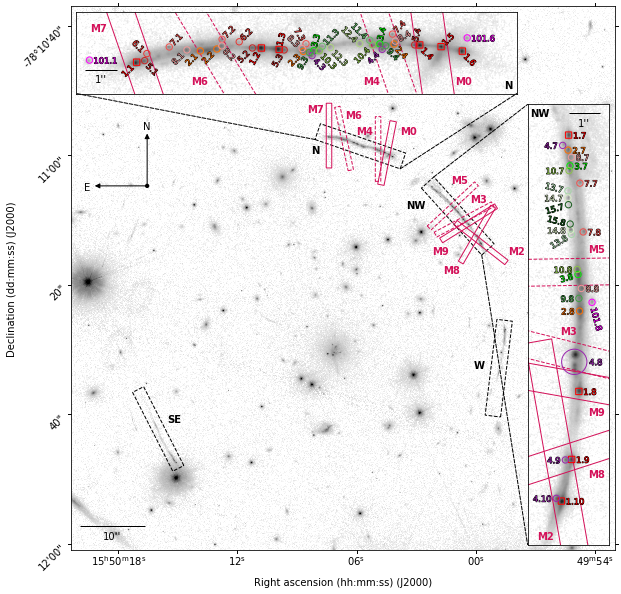

In [105]:
plot()